In [1]:
import pyemma
pyemma.__version__
import random as rndm

In [2]:
import matplotlib as mpltlib
import matplotlib.pylab as plt
import numpy as np
#import nglview as nv
%pylab inline
import mdtraj
import numpy as np

import pyemma.util.contexts


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/rabi/anaconda3/envs/msm/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    import pyemma
    pyemma.__version__
    import os
    %pylab inline
    matplotlib.rcParams.update({'font.size': 12})
    import pyemma.coordinates as coor
    import pyemma.msm as msm
    import pyemma.plots as mplt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
import pyemma.coordinates as coor

# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order 
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = ''
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

def plot_sampled_function(xall, yall, zall, ax=None, nbins=100, nlevels=20, cmap=cm.bwr, cbar=True, cbar_label=None):
    # histogram data
    xmin = np.min(xall)
    xmax = np.max(xall)
    dx = (xmax - xmin) / float(nbins)
    ymin = np.min(yall)
    ymax = np.max(yall)
    dy = (ymax - ymin) / float(nbins)
    # bin data
    eps = x
    xbins = np.linspace(xmin - 0.5*dx, xmax + 0.5*dx, num=nbins)
    ybins = np.linspace(ymin - 0.5*dy, ymax + 0.5*dy, num=nbins)
    xI = np.digitize(xall, xbins)
    yI = np.digitize(yall, ybins)
    # result
    z = np.zeros((nbins, nbins))
    N = np.zeros((nbins, nbins))
    # average over bins
    for t in range(len(xall)):
        z[xI[t], yI[t]] += zall[t]
        N[xI[t], yI[t]] += 1.0
    z /= N
    # do a contour plot
    extent = [xmin, xmax, ymin, ymax]
    if ax is None:
        ax = gca()
    ax.contourf(z.T, 100, extent=extent, cmap=cmap)
    if cbar:
        cbar = plt.colorbar()
        if cbar_label is not None:
            cbar.ax.set_ylabel(cbar_label)

    return ax

def plot_sampled_density(xall, yall, zall, ax=None, nbins=100, cmap=cm.Blues, cbar=True, cbar_label=None):
    return plot_sampled_function(xall, yall, zall, ax=ax, nbins=nbins, cmap=cmap, cbar=cbar, cbar_label=cbar_label)

def griddata(x, y, z, binsize=0.01, retbin=True, retloc=True):
    
    # get extrema values.
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # make coordinate arrays.
    xi      = np.arange(xmin, xmax+binsize, binsize)
    yi      = np.arange(ymin, ymax+binsize, binsize)
    xi, yi = np.meshgrid(xi,yi)

    # make the grid.
    grid           = np.zeros(xi.shape, dtype=x.dtype)
    nrow, ncol = grid.shape
    if retbin: bins = np.copy(grid)

    # create list in same shape as grid to store indices
    if retloc:
        wherebin = np.copy(grid)
        wherebin = wherebin.tolist()

    # fill in the grid.
    for row in range(nrow):
        for col in range(ncol):
            xc = xi[row, col]    # x coordinate.
            yc = yi[row, col]    # y coordinate.

            # find the position that xc and yc correspond to.
            posx = np.abs(x - xc)
            posy = np.abs(y - yc)
            ibin = np.logical_and(posx < binsize/2., posy < binsize/2.)
            ind  = np.where(ibin == True)[0]

            # fill the bin.
            bin = z[ibin]
            if retloc: wherebin[row][col] = ind
            if retbin: bins[row, col] = bin.size
            if bin.size != 0:
                binval         = np.median(bin)
                grid[row, col] = binval
            else:
                grid[row, col] = np.nan   # fill empty bins with nans.

    # return the grid
    if retbin:
        if retloc:
            return grid, bins, wherebin
        else:
            return grid, bins
    else:
        if retloc:
            return grid, wherebin
        else:
            return grid

In [5]:
## Reading the Topology and Trajectories


#indir = '.'
##prmtop error with mdtraj
#topfile =  'dry.monomer-1-oct.prmtop'
#traj_list = []
#for filename in os.listdir(indir):
#    if filename.endswith('.nc'):
#        traj_list.append(os.path.join(indir,filename))


indir = '.'
topfile =  'hdim-oct.inpcrd.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('.nc'):
        traj_list.append(os.path.join(indir,filename))

        
print(topfile)
print(traj_list)

hdim-oct.inpcrd.pdb
['./remd-4.nc', './remd-3.nc', './remd-5.nc', './remd-2.nc', './remd-1.nc']


In [6]:
atom_mol = 145
num_mol = 2

topology = mdtraj.load(topfile).topology

In [38]:
##These are used in the customized function of TICAgg

#back = topology.select("protein and backbone") #select backbone atoms only
back = topology.select("protein and name CA") #select C alpha atoms only
#back = topology.select("all") #select all atoms

In [39]:
list_select = numpy.split(back, num_mol, axis=0)
back1 = list_select[0]
back_atom = back1.size
dim_permute_sortintra = int((num_mol)*((back_atom)*(back_atom - 1)/2))
dim_permute_sortinter = int(((num_mol*(num_mol-1))/2)*(back_atom)*(back_atom)) #dimension of intra and intermolecular features

In [29]:
# def dist_intermol(traj):
    
#     nfram = traj.n_frames #number of frames in input mdtraj traj
#     distmat = np.zeros((nfram, (dim_permute_sortinter)), np.float32) #initialize our feature vector
#     k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
#     for i in back1:
#         for j in back1:
#             if (j == i): 
#                 pair_list = []
#                 for m in range(0, num_mol):
#                     for n in range(0, num_mol):
#                         if (m < n):
#                             pair_list.append([m*atom_mol+i, n*atom_mol+i])
#                 atom_pair = np.array(pair_list)
#                 dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
#                 dis_inter.sort(axis = 1)
#                 for m in range(0, int(num_mol*(num_mol-1)/2)):
#                     distmat[:,k_counter] = dis_inter[:,m]
#                     k_counter = k_counter + 1        
                    
#             if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES
#                 pair_list = []
#                 for m in range(0, num_mol):
#                     for n in range(0, num_mol):
#                         if (m < n):
#                             pair_list.append([m*atom_mol+i, n*atom_mol+j])
#                             pair_list.append([m*atom_mol+j, n*atom_mol+i])
#                 atom_pair = np.array(pair_list)
#                 dis_inter = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
#                 dis_inter.sort(axis = 1)
#                 for m in range(0, int(num_mol*(num_mol-1))):
#                     distmat[:,k_counter] = dis_inter[:,m]
#                     k_counter = k_counter + 1
    
#     return distmat                        

In [40]:
def dist_intramol(traj):
    
    nfram = traj.n_frames #number of frames in input mdtraj traj
    distmat = np.zeros((nfram, (dim_permute_sortintra)), np.float32) #initialize our feature vector
    k_counter = 0 #this one keeps track of the column number of the feature vector that we will update
    
    for i in back1:
        for j in back1:
            if (j < i): #ONLY LOWER DIAGONAL ELEMENTS TO AVOID THE SAME DISTANCES OR SELF-DISTANCES
                pair_list = []
                for m in range(0, num_mol):
                    pair_list.append([m*atom_mol+i, m*atom_mol+j])
                atom_pair = np.array(pair_list)                
                dis_intra = mdtraj.compute_distances(traj, atom_pair, periodic=True, opt=True)
                dis_intra.sort(axis = 1)
                for m in range(0, num_mol):
                    distmat[:,k_counter] = dis_intra[:,m]
                    k_counter = k_counter + 1
    
    return distmat

In [41]:
# feat = coor.featurizer(topfile)
# feat.add_custom_func(dist_intermol, dim_permute_sortinter)


feat = coor.featurizer(topfile)
feat.add_custom_func(dist_intramol, dim_permute_sortintra) # ADD INTRAMOLECULAR DISTANCE

In [42]:
from pyemma import config
config.show_progress_bars = False

In [43]:
traj_length = 50000
inp = coor.source(traj_list, feat)
print ('number of trajectories = ',inp.number_of_trajectories())
print ('trajectory length = ',inp.trajectory_length(0))
print ('trajectory time step = ', traj_length/ (inp.trajectory_length(0)-1),'ns')
print ('number of dimension = ',inp.dimension())

number of trajectories =  5
trajectory length =  50000
trajectory time step =  1.000020000400008 ns
number of dimension =  90


In [49]:
#inp1 = coor.load(traj_list, features=feat)

In [23]:
# def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    
#     """Compute a cross-validated VAMP2 score.
# # 
#     We randomly split the list of independent trajectories into
#     a training and a validation set, compute the VAMP2 score,
#     and repeat this process several times.

#     Parameters
#     ----------
#     data : list of numpy.ndarrays
#         The input data.
#     dim : int
#         Number of processes to score; equivalent to the dimension
#         after projecting the data with VAMP2.
#     lag : int
#         Lag time for the VAMP2 scoring.
#     number_of_splits : int, optional, default=10
#         How often do we repeat the splitting and score calculation.
#     validation_fraction : int, optional, default=0.75
#         Fraction of trajectories which should go into the validation
#         set during a split.
#     """
#     # we temporarily suppress very short-lived progress bars
#     # nval = int(len(data) * validation_fraction)
#     # scores = np.zeros(number_of_splits)
#     # for n in range(number_of_splits):
#     #     data_validation = []
#     #     for n1 in range(number_of_splits):
#     #         if n1!=n:
#     #             data_validation.append(n1)
#     #     ival = np.array(data_validation)
#     #     print(ival)
#     #     vamp = pyemma.coordinates.vamp([d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
#     #     scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
#     # return scores
    
#     nval = int(len(data) * validation_fraction)
#     scores = np.zeros(number_of_splits)
#     for n in range(number_of_splits):
#         ival = np.random.choice(len(data), size=nval, replace=False)
#         vamp = pyemma.coordinates.vamp([d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
#         scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
#     return scores



In [50]:
# # lags = [100,200,300,400,500]
# # dims = [2,4,6,8,10]
# # lags = [200,300,400,500]
# # dims = [2,6,10]

# lags = [100,250,375,500,750,1000]
# dims = [2,4,6,8,10]

# fig, ax = plt.subplots()
# for i, lag in enumerate(lags):
#     print('Calculation for Lag Time (in MD steps):' + str(lag))
#     scores_ = np.array([score_cv(inp, dim, lag)
#                         for dim in dims])
#     scores = np.mean(scores_, axis=1)
#     errors = np.std(scores_, axis=1, ddof=1)
#     color = 'C{}'.format(i)
#     ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
#     ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.02))
# ax.legend()
# ax.set_xlabel('number of dimensions')
# ax.set_ylabel('VAMP2 score')
# fig.tight_layout()

In [44]:
lag = 250
dim = 4
tica_obj = coor.tica(inp, lag = lag, dim = dim, kinetic_map = True)

/home/rabi/anaconda3/envs/msm/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rabi/anaconda3/envs/msm/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


In [45]:
Y = tica_obj.get_output()

Y1 = np.concatenate(Y)

Text(0.5, 0, 'time (40 micros)')

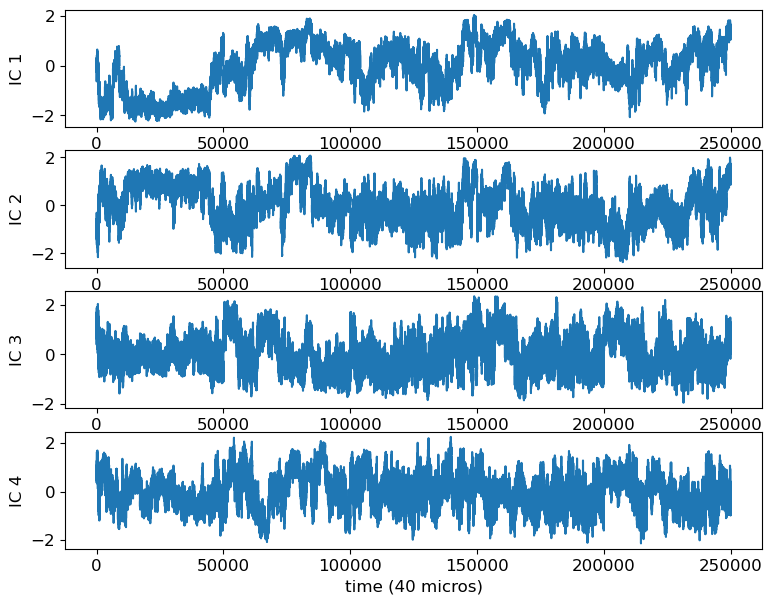

In [46]:
figure(figsize=(9,7))
plt.subplot2grid((4,1),(0,0))
plt.plot(Y1[:,0])
plt.ylabel('IC 1')
plt.subplot2grid((4,1),(1,0))
plt.plot(Y1[:,1])
plt.ylabel('IC 2')
plt.subplot2grid((4,1),(2,0))
plt.plot(Y1[:,2])
plt.ylabel('IC 3')
plt.subplot2grid((4,1),(3,0))
plt.plot(Y1[:,3])
plt.ylabel('IC 4')
# plt.subplot2grid((8,1),(4,0))
# plt.plot(Y1[:,0])
# plt.ylabel('IC 5')
# plt.subplot2grid((8,1),(5,0))
# plt.plot(Y1[:,1])
# plt.ylabel('IC 6')
# plt.subplot2grid((8,1),(6,0))
# plt.plot(Y1[:,2])
# plt.ylabel('IC 7')
# plt.subplot2grid((8,1),(7,0))
# plt.plot(Y1[:,3])
# plt.ylabel('IC 8')
plt.xlabel('time (40 micros)')

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Feature values'>)

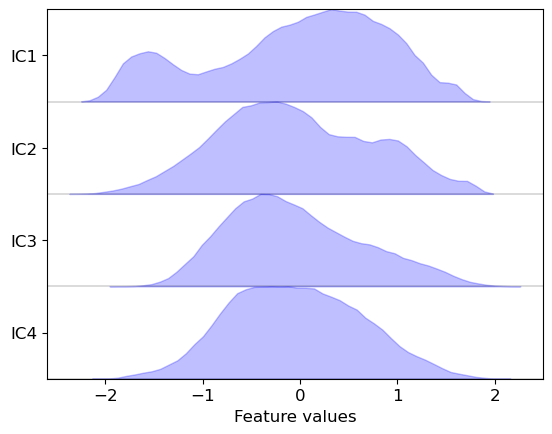

In [47]:
mplt.plot_feature_histograms(Y1, feature_labels=['IC1','IC2','IC3','IC4'])

/tmp/ipykernel_8582/773581906.py:13: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)


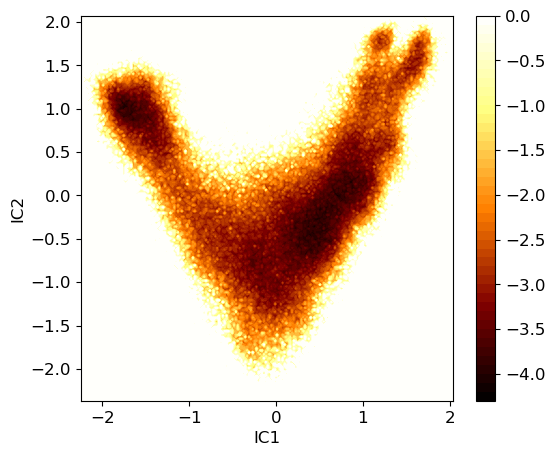

In [48]:
tica0 = np.array([])
tica1 = np.array([])
for j in range(len(Y)):
    tica0 = np.concatenate((tica0, Y[j][:,0]))

for j in range(len(Y)):
    tica1 = np.concatenate((tica1, Y[j][:,1]))
    
# histogram data
z,x,y = np.histogram2d(tica0, tica1, bins=200)
extent = (x.min(), x.max(), y.min(), y.max()) # extent of the plot
# compute free energies
F = -np.log(z)
F[F == inf] = -1000
maxval = np.amax(F)
F[F == -1000] = maxval
plt.figure(figsize=(6,5))
plt.contourf(F.T, 50, cmap=plt.cm.afmhot, extent = extent)
plt.colorbar()
plt.ylabel('IC2')
plt.xlabel('IC1')
plt.show()

del(tica0)
del(tica1)